## 📌 라이브러리 

#### 1. 환경 설정
  - 데이터 분석 및 모델링을 위한 기본 라이브러리 설치

#### 2. 설치할 패키지

- `numpy`  
  - 수치 계산·배열 연산  
- `pandas`  
  - 데이터프레임 생성·처리  
- `matplotlib`  
  - 기본 시각화  
- `seaborn`  
  - 고급 시각화 (히트맵 등)  
- `scikit-learn`  
  - 전처리·모델 학습·평가  
- `joblib`  
  - 병렬 처리 및 모델 저장  

#### 3. 설치 명령어
conda install -y \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    scikit-learn \
    joblib


In [1]:
# 기본 유틸리티 및 시각화 
import numpy as np                     # 수치 계산·배열
import pandas as pd                    # 데이터프레임 처리
import matplotlib.pyplot as plt        # 기본 시각화
import seaborn as sns                  # 고급 시각화 (heatmap 등)
import matplotlib.gridspec as gridspec # 복잡한 서브플롯 레이아웃

# 전처리 관련 
from sklearn.impute import SimpleImputer          # 결측치 대체
from sklearn.preprocessing import (
    StandardScaler,                               # 수치형 스케일링
    LabelEncoder,                                 # 타깃 라벨 인코딩
    label_binarize                                # 다중 클래스 ROC용 이진 인코딩
)

# 모델 학습 / 튜닝 관련 
from sklearn.model_selection import (
    train_test_split,                             # 학습-테스트 분할
    StratifiedKFold,                              # 계층적 KFold
    RandomizedSearchCV,                           # 랜덤 탐색
    GridSearchCV,                                 # 그리드 탐색
    ParameterGrid                                 # 파라미터 공간 크기 계산 (n_iter 자동화용)
)
from sklearn.experimental import enable_halving_search_cv  # Halving* 사용 시 필수 활성화
import joblib                               # 병렬 backend 제어 (워커 중단 방지용)

# 파이프라인 구성 
from sklearn.pipeline import Pipeline                    # 전체 워크플로우 파이프라인
from sklearn.compose import ColumnTransformer            # 컬럼별 전처리 (숫자/범주 분리)

# 분류 모델
from sklearn.linear_model import LogisticRegression      # 로지스틱 회귀
from sklearn.neighbors import KNeighborsClassifier       # K-최근접 이웃
from sklearn.tree import DecisionTreeClassifier          # 결정 트리
from sklearn.ensemble import RandomForestClassifier      # 랜덤 포레스트

# 평가 지표 및 분석 도구 
from sklearn.metrics import (
    accuracy_score,                         # 정확도
    precision_score,                        # 정밀도
    recall_score,                           # 재현율
    f1_score,                               # F1 점수
    classification_report,                  # 분류 리포트
    confusion_matrix,                       # 혼동 행렬
    roc_curve,                              # ROC 곡선
    auc,                                    # AUC 계산
    precision_recall_curve,                 # PR 곡선
    average_precision_score                 # Average Precision(AP)
)

## 📌 A. 데이터 다운로드 및 데이터셋 확인

In [2]:
# 설정
csv_path     = 'wine.csv'                                 # 원본 CSV 파일 경로
sample_frac  = 0.1                                        # 전체에서 사용할 샘플 비율 (10%)
random_state = 42                                         # 샘플링 및 모델 학습 시 재현성 보장을 위한 시드 값
source       = "samuelmcguire/wine-reviews-data (Kaggle)"  # 데이터 출처 정보

# 1) 원본 데이터 로드 및 기본 확인
full_data = pd.read_csv(csv_path)                         # CSV 파일을 읽어 DataFrame으로 저장
print("원본 데이터셋 크기:", full_data.shape)             # 전체 샘플 수 × 변수 수 출력
print(full_data.head())                                   # 상위 5개 샘플 조회

# 2) 10% 샘플링
df = full_data.sample(frac=sample_frac, random_state=random_state)  
# • frac: 전체의 몇 %를 샘플링할지 지정
# • random_state: 매번 같은 샘플을 뽑도록 고정

# 3) 샘플 데이터 요약 및 변수 정의
print("출처:", source)                                     # 데이터 출처 출력
print("샘플 데이터 크기:", df.shape)                      # 샘플링 후 크기 확인

# • 종속변수(target) 지정
target_col   = "variety"                                  # 예측할 타겟 변수: 와인 품종

# • 독립변수(feature) 지정
feature_cols = [col for col in df.columns if col != target_col]  
#   타겟 변수를 제외한 모든 컬럼을 피처로 설정

print("종속변수:", target_col)                            # 타겟 변수 이름 출력
print("독립변수 예시:", feature_cols[:10], "...")         # 피처 중 일부 예시 출력
print(df.head())                                          # 샘플 데이터 재확인


원본 데이터셋 크기: (323237, 11)
                                                wine                winery  \
0  J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...               J. Lohr   
1            Antucura 2010 Pinot Noir (Vista Flores)              Antucura   
2  Quinta do Portal 1999 Quinta do Portal Reserva...      Quinta do Portal   
3  Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana)    Tenuta di Ghizzano   
4  Tenuta San Francesco 2007 Tramonti White (Camp...  Tenuta San Francesco   

  category               designation                varietal  \
0      Red          Hilltop Vineyard      Cabernet Sauvignon   
1      Red                       NaN              Pinot Noir   
2      Red  Quinta do Portal Reserva  Red Blends, Red Blends   
3      Red               Il Ghizzano  Red Blends, Red Blends   
4    White                  Tramonti             White Blend   

                                  appellation alcohol price  rating  \
0  Paso Robles, Central Coast, California, US     

## 📌 B. 데이터 전처리

### 결측치 처리

In [3]:
# 결측치 확인
# • df.isnull().sum(): 각 컬럼별 결측치 개수 집계
print("결측치 처리 전:\n", df.isnull().sum(), "\n")

# 수치형 변수 변환
# • price_num: 'price'에서 숫자 및 소수점만 남기고 제거 후 float 변환
df['price_num'] = pd.to_numeric(
    df['price'].str.replace(r'[^\d.]', '', regex=True),  # 숫자·'.' 외 문자 제거
    errors='coerce'                                      # 변환 불가 시 NaN
)
# • alcohol_num: 'alcohol'에서 '%' 제거 후 float 변환
df['alcohol_num'] = pd.to_numeric(
    df['alcohol'].str.rstrip('%'),  # 끝 '%' 제거
    errors='coerce'                 # 변환 불가 시 NaN
)
# 결측치 대체 대상 컬럼 정의
num_cols = ['rating', 'price_num', 'alcohol_num']  
# • 수치형 변수 리스트
cat_cols = [
    c for c in df.columns
    if df[c].dtype == 'object' and c != target_col
]
# • 범주형(object) 변수 중 타겟(variety) 제외

# imputer 적용: sklearn.impute.SimpleImputer 사용
from sklearn.impute import SimpleImputer

# • 수치형: 중앙값(median)으로 결측치 대체
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# • 범주형: 최빈값(most_frequent)으로 결측치 대체
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# 결측치 처리 후 확인
# • 모든 결측치가 적절히 대체되었는지 재검증
print("결측치 처리 후:\n", df.isnull().sum(), "\n")

결측치 처리 전:
 wine              0
winery            0
category          0
designation    9233
varietal       2098
appellation     260
alcohol        4042
price          2389
rating            0
reviewer       7347
review           91
dtype: int64 

결측치 처리 후:
 wine           0
winery         0
category       0
designation    0
varietal       0
appellation    0
alcohol        0
price          0
rating         0
reviewer       0
review         0
price_num      0
alcohol_num    0
dtype: int64 



### 범주형 인코딩 및 확인

In [4]:
# 인코딩 전 데이터 크기 및 샘플 확인
# • 범주형 변수 개수가 많아지기 전 원본 df의 shape 확인
print("인코딩 전 shape:", df.shape)
# 실제 범주형 값
print(df[cat_cols].head(), "\n")

# One-Hot Encoding
# • pd.get_dummies: 지정한 범주형 컬럼을 더미(0/1) 변수로 변환
# • drop_first=True: 기준 클래스 하나를 제거해 다중공선성 방지
df_enc = pd.get_dummies(
    df,
    columns=cat_cols,     # 인코딩할 범주형 컬럼 리스트
    drop_first=True       # 첫 번째 수준(level) 제거
)

# 인코딩 후 결과 확인
# • 새로운 df_enc의 shape 출력: 피처 수가 크게 증가했는지 확인
print("인코딩 후 shape:", df_enc.shape)
# • 인코딩 후 생성된 컬럼 이름 일부 출력
print("인코딩 후 columns (일부):", df_enc.columns.tolist()[:10], "\n")

인코딩 전 shape: (32324, 13)
                                                     wine  \
240046  Herdade de São Miguel 2012 Herdade da Pimenta ...   
322563  Fowles Wine 2018 Ladies who Shoot their Lunch ...   
143268  Terre di Talamo 2012 Tempo Riserva  (Morellino...   
123088     Pascal Jolivet 2010 Les Caillottes  (Sancerre)   
20172   Château de Santenay 2014 Clos Philippe le Hard...   

                       winery category  \
240046  Herdade de São Miguel      Red   
322563            Fowles Wine    White   
143268        Terre di Talamo      Red   
123088         Pascal Jolivet    White   
20172     Château de Santenay      Red   

                                      designation                varietal  \
240046                         Herdade da Pimenta          Portuguese Red   
322563  Ladies who Shoot their Lunch Wild Ferment              Chardonnay   
143268                              Tempo Riserva  Red Blends, Red Blends   
123088                             Les Caillott

### 스케일링 전·후 통계 확인

In [5]:
# 스케일링 전 수치형 변수 통계 확인
# • mean, std 집계로 변수 분포 확인
print("스케일링 전 통계:\n", df_enc[num_cols].agg(['mean', 'std']), "\n")

# StandardScaler 객체 생성
# • 평균 0, 분산 1로 표준화 수행
scaler = StandardScaler()

# 스케일링 적용
# • fit_transform: 데이터에 맞춰 학습 후 변환
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

# 스케일링 후 수치형 변수 통계 확인
# • 평균이 0 근처, 표준편차가 1 근처인지 검증
print("스케일링 후 통계:\n", df_enc[num_cols].agg(['mean', 'std']), "\n")

스케일링 전 통계:
          rating  price_num  alcohol_num
mean  88.580219  34.679300    13.976180
std    3.185725  40.386132    50.426789 

스케일링 후 통계:
             rating     price_num   alcohol_num
mean -2.125649e-15  2.167415e-16 -3.319266e-17
std   1.000015e+00  1.000015e+00  1.000015e+00 



### 샘플 시각화(EDA)

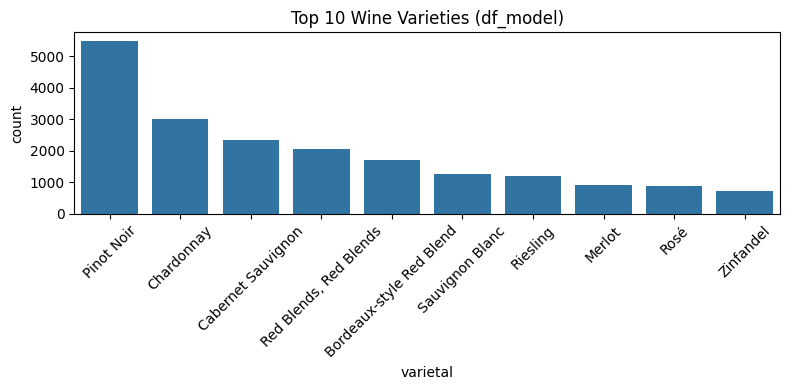

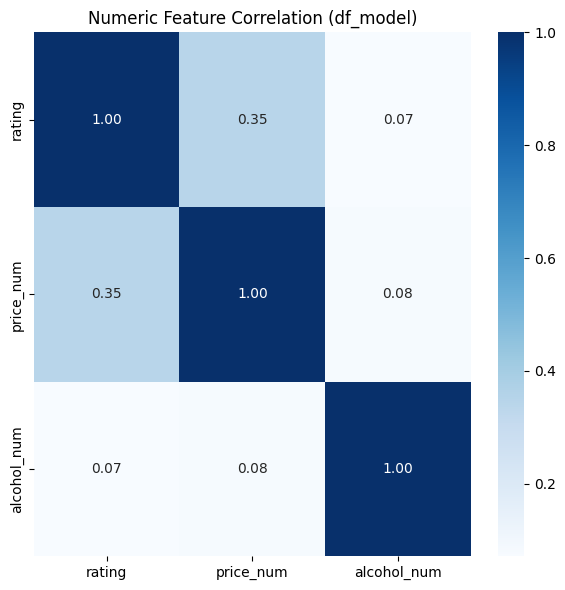

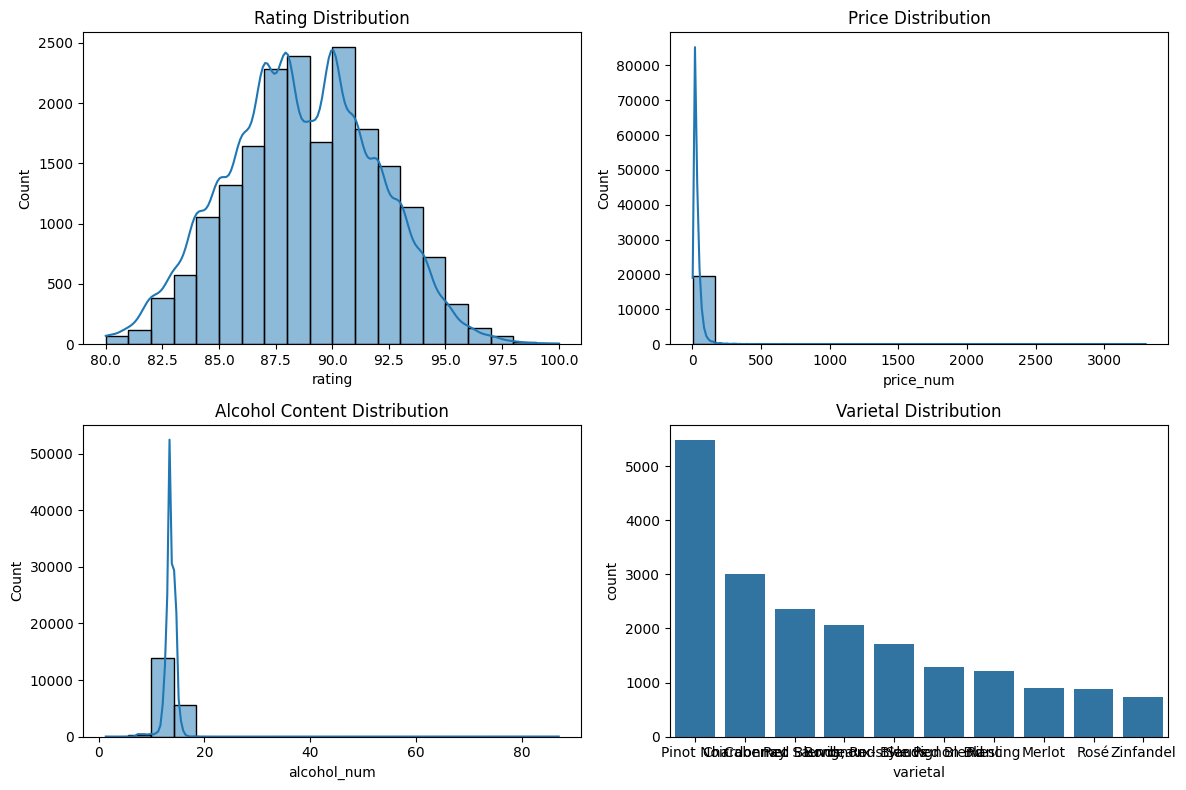

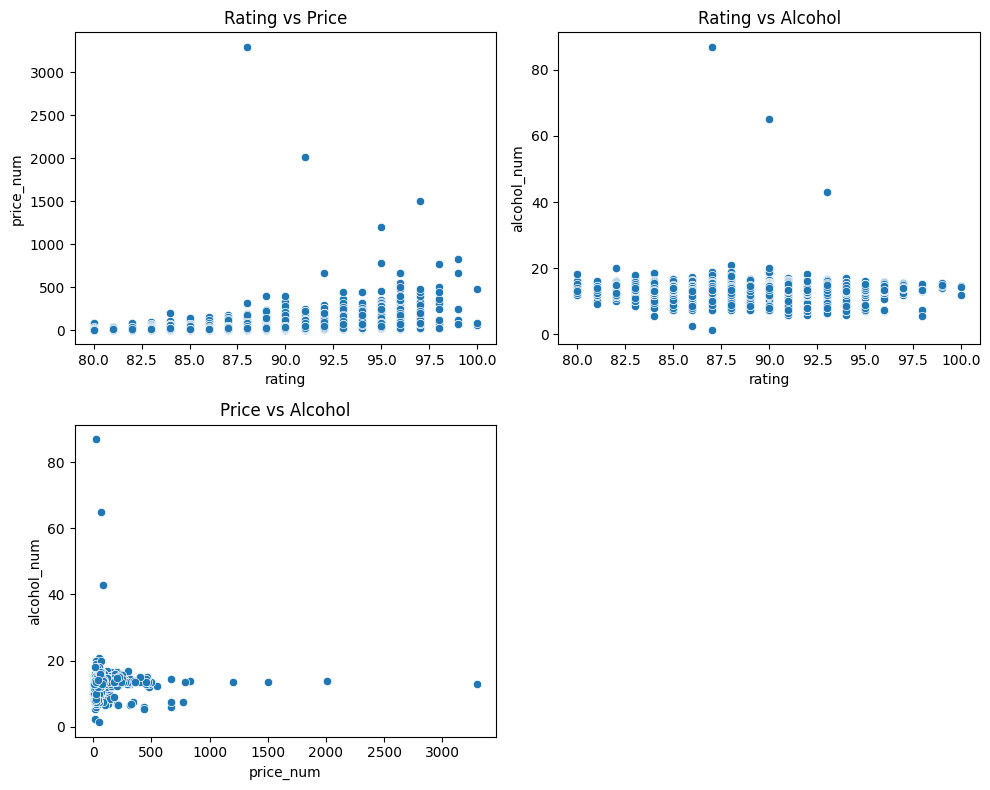

In [6]:
# 상위 10개 와인 품종만 선택하여 분석용 데이터프레임 생성
top10 = df['varietal'].value_counts().nlargest(10).index
df_model = df[df['varietal'].isin(top10)].copy()

# 클래스 분포 시각화하여 데이터 균형 상태 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_model,
    x='varietal',
    order=top10
)
plt.title('Top 10 Wine Varieties (df_model)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 주요 수치형 특성 간 상관관계를 히트맵으로 시각화하여 변수 간 관계 파악
num_cols = ['rating', 'price_num', 'alcohol_num']
plt.figure(figsize=(6, 6))
sns.heatmap(
    df_model[num_cols].corr(),
    annot=True,
    fmt='.2f',
    cmap='Blues'
)
plt.title('Numeric Feature Correlation (df_model)')
plt.tight_layout()
plt.show()

# 수치형 변수 분포를 히스토그램으로 시각화하여 데이터 분포 형태 확인
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(df_model['rating'], kde=True, bins=20)
plt.title('Rating Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df_model['price_num'], kde=True, bins=20)
plt.title('Price Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df_model['alcohol_num'], kde=True, bins=20)
plt.title('Alcohol Content Distribution')

plt.subplot(2, 2, 4)
sns.countplot(
    data=df_model,
    x='varietal',
    order=top10
)
plt.title('Varietal Distribution')

plt.tight_layout()
plt.show()

# 변수 간 산점도를 통해 상관 패턴 및 이상치 탐색
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df_model, x='rating', y='price_num')
plt.title('Rating vs Price')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df_model, x='rating', y='alcohol_num')
plt.title('Rating vs Alcohol')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df_model, x='price_num', y='alcohol_num')
plt.title('Price vs Alcohol')

plt.tight_layout()
plt.show()

## 📌 C. 분류 모델 구현

### 데이터 분할

In [7]:
# 상위 열 와인 품종의 데이터만 선택하여 새로운 데이터프레임 생성
top_varieties = df['varietal'].value_counts().nlargest(10).index
df_model = df[df['varietal'].isin(top_varieties)].copy()  # 원본 인덱스 유지

# price와 alcohol 컬럼에서 숫자만 추출하여 새로운 수치형 변수 생성
df_model['price_num'] = pd.to_numeric(
    df_model['price'].str.replace(r'[^\d.]','', regex=True),
    errors='coerce'
)
df_model['alcohol_num'] = pd.to_numeric(
    df_model['alcohol'].str.rstrip('%'),
    errors='coerce'
)

# 타깃 변수(varietal)를 레이블 인코더로 정수형으로 변환
encoder = LabelEncoder()
df_model['varietal_enc'] = encoder.fit_transform(df_model['varietal'])

# 모델 학습에 사용할 피처와 정답 변수 설정
features = ['rating', 'price_num', 'alcohol_num']
X = df_model[features]
y = df_model['varietal_enc']

# 학습 데이터와 테스트 데이터를 클래스 비율 유지하며 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 테스트 데이터 비율 지정
    stratify=y,             # 클래스 분포 유지
    random_state=42         # 재현성 확보
)

### 파이프라인 구성 및 모델 훈련

In [8]:
# 전처리: 결측치 대체와 표준화를 위한 파이프라인 구성
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # 중앙값으로 결측치 대체
    ('scaler',   StandardScaler())                  # 평균0/표준편차1로 표준화
])

# ColumnTransformer를 사용해 지정한 수치형 변수에만 전처리 적용
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, ['rating', 'price_num', 'alcohol_num'])
])

# 로지스틱 회귀 파이프라인: 전처리 후 로지스틱 회귀 분류기 학습
pipe_lr = Pipeline([
    ('preprocessing', preprocessor),                # 수치형 전처리 단계
    ('clf', LogisticRegression(                     # 로지스틱 회귀 분류기
        max_iter=1000,                              # 최대 반복 횟수 설정
        random_state=42,                           # 결과 재현성 고정
        class_weight='balanced'                    # 클래스 불균형 보정
    ))
])

# K-최근접 이웃 파이프라인: 전처리 후 KNN 분류기 학습
pipe_knn = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', KNeighborsClassifier())                 # 기본 KNN 설정 사용
])

# 결정 트리 파이프라인: 전처리 후 결정 트리 분류기 학습
pipe_dt = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', DecisionTreeClassifier(
        random_state=42,                           # 결과 재현성 고정
        class_weight='balanced'                    # 클래스 불균형 보정
    ))
])

# 랜덤 포레스트 파이프라인: 전처리 후 앙상블 분류기 학습
pipe_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,                          # 사용할 트리 개수 설정
        random_state=42,                           # 결과 재현성 고정
        class_weight='balanced'                    # 클래스 불균형 보정
    ))
])

# 모든 모델을 dictionary에 저장하여 일괄 학습 가능하도록 구성
models = {
    'LogisticRegression': pipe_lr,
    'KNeighbors'        : pipe_knn,
    'DecisionTree'      : pipe_dt,
    'RandomForest'      : pipe_rf
}

# 저장된 모든 파이프라인 모델을 학습 데이터로 학습
for name, model in models.items():
    model.fit(X_train, y_train)  # 훈련 데이터로 모델 최적화

## 📌 D. 성능평가

In [9]:
# 레이블 인코더 변수명 통일
le = encoder  # 이전에 정의한 encoder 객체를 le로 참조

# 클래스 수 계산
n_classes = len(le.classes_)

# 테스트 레이블을 이진 배열로 변환
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# 테스트 레이블을 다중 클래스 ROC/PR 계산용 이진 배열로 변환
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# 기본 모델 성능 평가 결과를 저장할 리스트
results_default = []

# 각 모델별로 예측 수행 및 평가 지표 계산 반복
for name, model in models.items():
    # 예측 결과와 클래스별 확률 예측
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # 정확도 계산
    acc = accuracy_score(y_test, y_pred)
    # 클래스별 Precision의 평균
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    # 클래스별 Recall의 평균
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    # 클래스별 F1의 평균
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # 다중 클래스 ROC-AUC(macro) 계산
    all_fpr = np.unique(
        np.concatenate([
            roc_curve(y_test_bin[:, i], y_prob[:, i])[0]
            for i in range(n_classes)
        ])
    )
    mean_tpr = sum(
        np.interp(all_fpr, *roc_curve(y_test_bin[:, i], y_prob[:, i])[:2])
        for i in range(n_classes)
    ) / n_classes
    roc_auc = auc(all_fpr, mean_tpr)

    # 평균 Precision-Recall(AP)(micro) 계산
    ap = average_precision_score(y_test_bin, y_prob, average='micro')

    # 계산된 지표를 딕셔너리 형태로 리스트에 추가
    results_default.append({
        'Model': name,
        'Accuracy': acc,
        'Precision_macro': prec,
        'Recall_macro': rec,
        'F1_macro': f1,
        'ROC_AUC_macro': roc_auc,
        'AP_micro': ap
    })

# 평가 결과를 DataFrame으로 변환하여 출력
df_default_results = pd.DataFrame(results_default).set_index('Model')
print("Default 모델 성능")
print(df_default_results)

Default 모델 성능
                    Accuracy  Precision_macro  Recall_macro  F1_macro  \
Model                                                                   
LogisticRegression  0.183206         0.206275      0.271579  0.186316   
KNeighbors          0.283715         0.262538      0.235611  0.238542   
DecisionTree        0.229262         0.222814      0.246461  0.221935   
RandomForest        0.259033         0.240258      0.265512  0.245283   

                    ROC_AUC_macro  AP_micro  
Model                                        
LogisticRegression       0.712129  0.217803  
KNeighbors               0.638314  0.225960  
DecisionTree             0.615893  0.181306  
RandomForest             0.681361  0.253846  


### 시각화

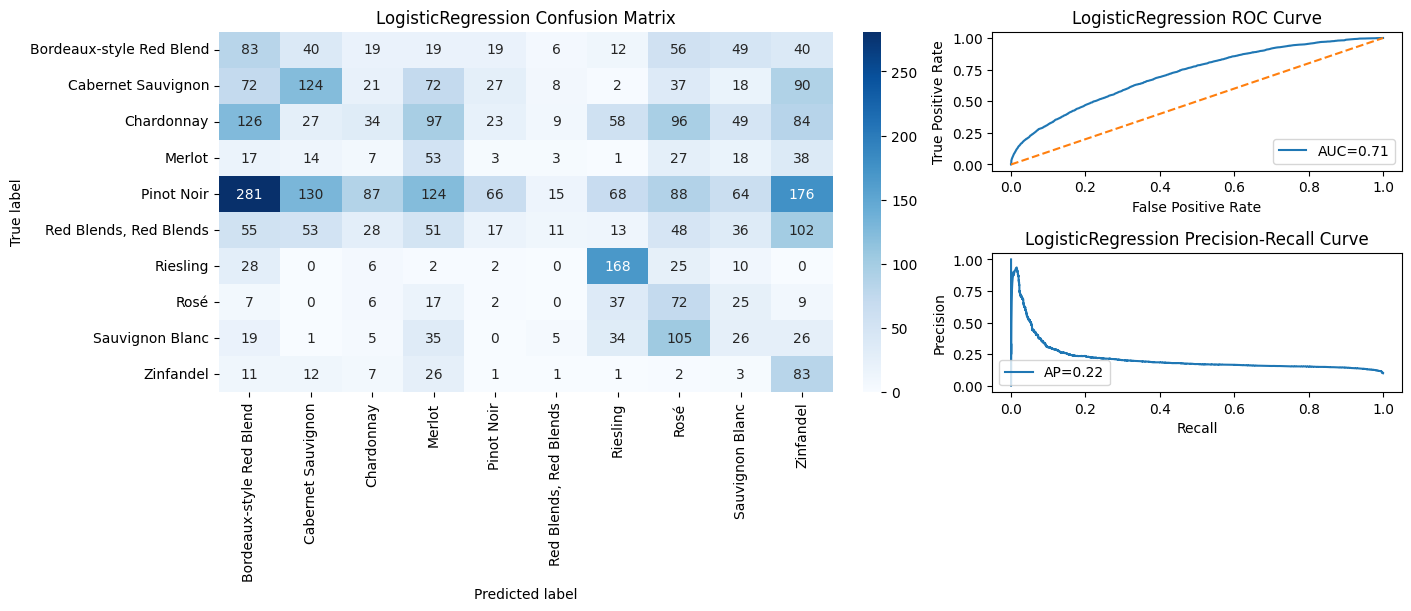

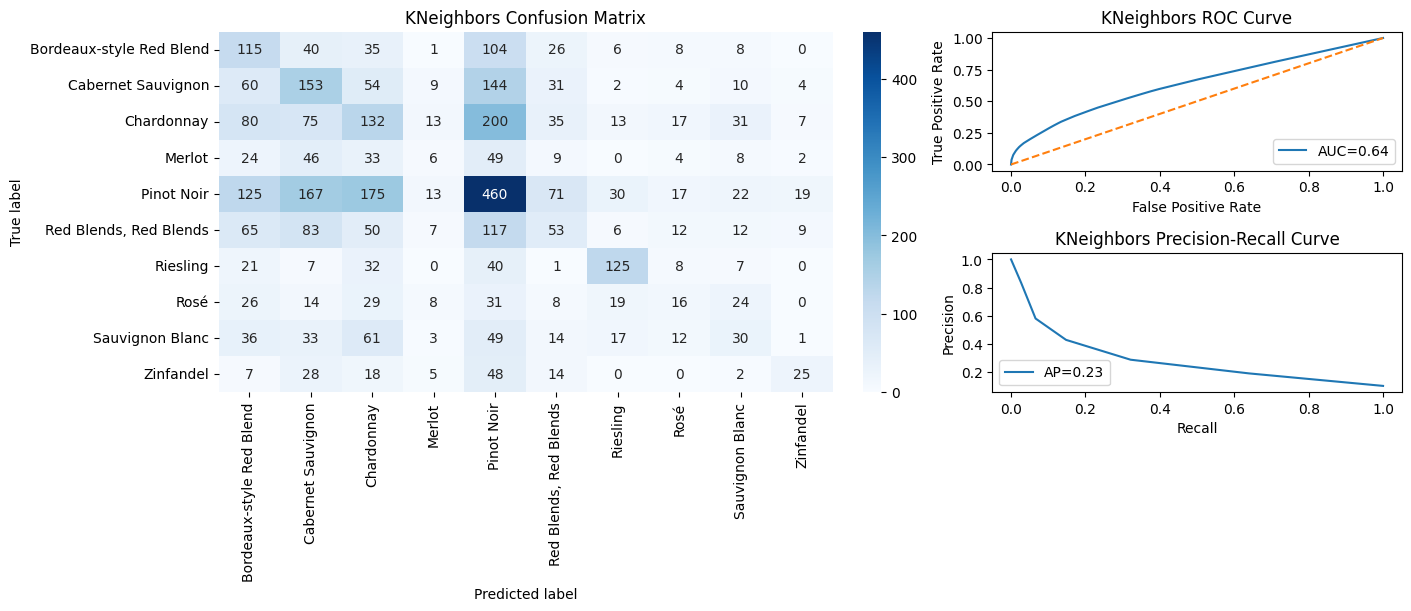

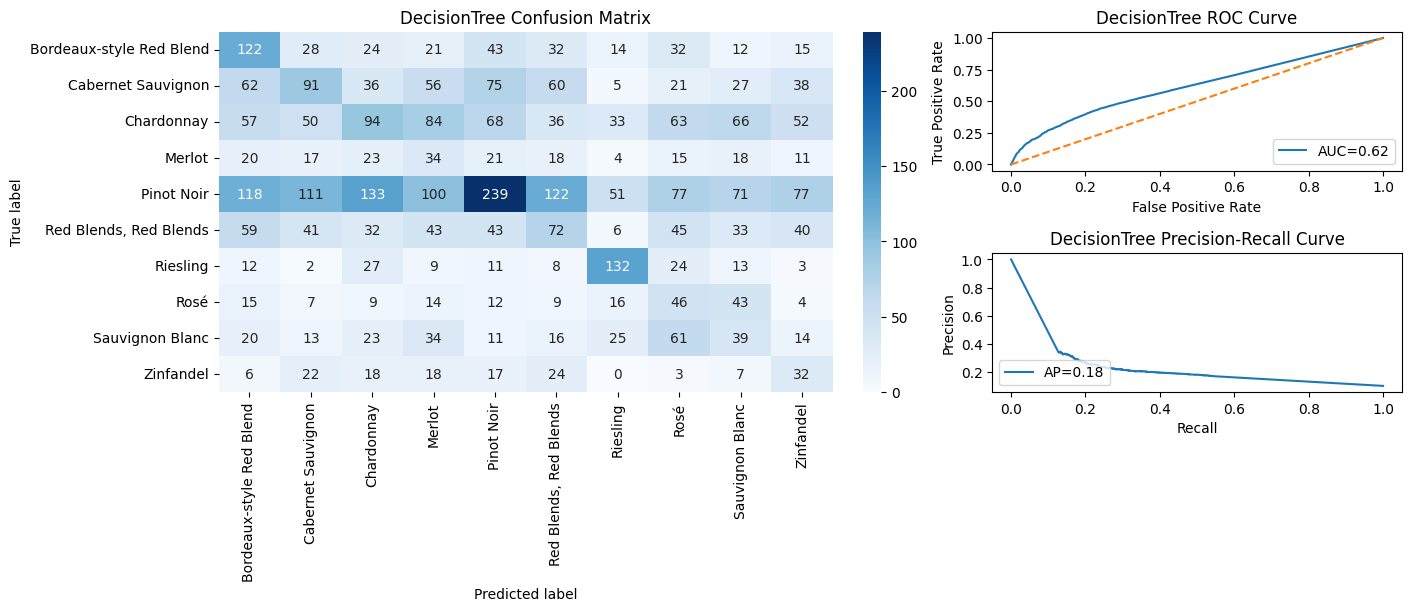

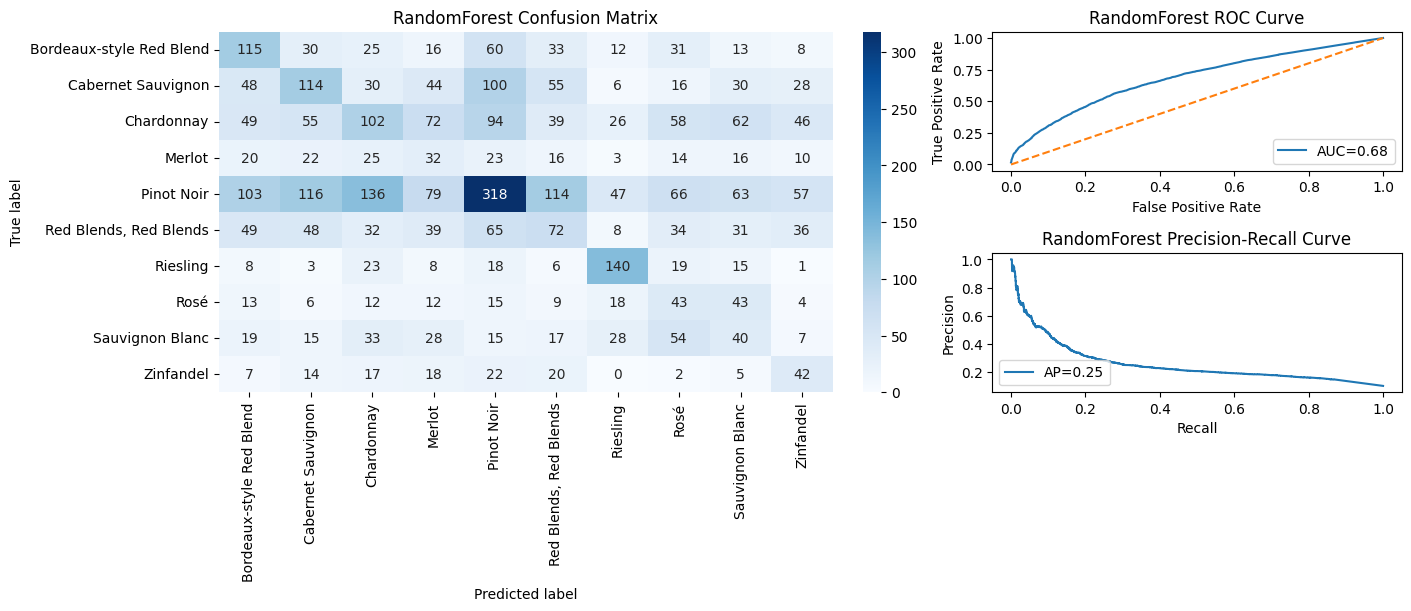

In [10]:
# 기본 모델로 각 분류기의 성능 시각화
for name, model in models.items():
    # 테스트 세트에 대한 클래스 예측과 확률값 계산
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # 실제값과 예측값으로 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)

    # 모든 클래스의 ROC 곡선을 통합해 평균 FPR과 TPR 계산
    all_fpr = np.unique(np.concatenate([
        roc_curve(y_test_bin[:, i], y_prob[:, i])[0]
        for i in range(n_classes)
    ]))
    mean_tpr = sum(
        np.interp(all_fpr, *roc_curve(y_test_bin[:, i], y_prob[:, i])[:2])
        for i in range(n_classes)
    ) / n_classes
    roc_auc = auc(all_fpr, mean_tpr)

    # 이진화된 레이블과 확률값으로 Precision-Recall 커브와 평균 정밀도 계산
    precision, recall, _ = precision_recall_curve(
        y_test_bin.ravel(), y_prob.ravel()
    )
    ap = average_precision_score(y_test_bin, y_prob, average='micro')

    # 혼동 행렬, ROC 곡선, PR 곡선을 하나의 Figure에 배치
    fig = plt.figure(constrained_layout=True, figsize=(14, 6))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1.5, 1])

    # 혼동 행렬 히트맵 그리기
    ax0 = fig.add_subplot(spec[:, 0])
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=le.classes_, yticklabels=le.classes_,
        ax=ax0
    )
    ax0.set_title(f'{name} Confusion Matrix')
    ax0.set_xlabel('Predicted label')
    ax0.set_ylabel('True label')

    # ROC 곡선 그리기 및 AUC 값 표시
    ax1 = fig.add_subplot(spec[0, 1])
    ax1.plot(all_fpr, mean_tpr, label=f'AUC={roc_auc:.2f}')
    ax1.plot([0, 1], [0, 1], linestyle='--')
    ax1.set_title(f'{name} ROC Curve')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right')

    # Precision-Recall 곡선 그리기 및 AP 값 표시
    ax2 = fig.add_subplot(spec[1, 1])
    ax2.plot(recall, precision, label=f'AP={ap:.2f}')
    ax2.set_title(f'{name} Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend(loc='lower left')

    # 화면에 시각화 결과 출력
    plt.show()

## 📌 E. 하이퍼파라미터 튜닝

In [11]:
# 교차검증을 위한 StratifiedKFold 설정: 클래스 비율을 유지하며 폴드 분할
cv = StratifiedKFold(
    n_splits=5,            # 폴드 개수 지정
    shuffle=True,          # 데이터를 섞어서 분할
    random_state=42        # 재현성 확보를 위한 시드 고정
)

# 각 모델별 하이퍼파라미터 탐색 공간 정의
param_grids = {
    'LogisticRegression': [
        {
            'clf__solver': ['lbfgs'], 
            'clf__penalty': ['l2'],
            'clf__C': [1e-3, 1e-2, 1e-1, 1, 10, 100]
        },
        {
            'clf__solver': ['saga'], 
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    ],
    'KNeighbors': {
        'clf__n_neighbors': list(range(3, 32, 2)),  
        'clf__weights'    : ['uniform', 'distance'], 
        'clf__p'          : [1, 2]                 
    },
    'DecisionTree': {
        'clf__criterion'         : ['gini', 'entropy'], 
        'clf__max_depth'         : [None, 5, 10, 20, 40], 
        'clf__min_samples_split' : [2, 5, 10], 
        'clf__min_samples_leaf'  : [1, 2, 4]
    },
    'RandomForest': {
        'clf__n_estimators'      : [100, 200, 300, 400], 
        'clf__max_depth'         : [None, 10, 20, 30], 
        'clf__min_samples_split' : [2, 5], 
        'clf__min_samples_leaf'  : [1, 2], 
        'clf__max_features'      : ['sqrt', 'log2'], 
        'clf__bootstrap'         : [True]
    }
}

# 최적 모델과 파라미터를 저장할 딕셔너리 초기화
best_models, best_params = {}, {}

# 로지스틱회귀, KNN, 결정트리 모델에 대한 랜덤 탐색 수행
for name in ['LogisticRegression', 'KNeighbors', 'DecisionTree']:
    grid = param_grids[name]
    total_space = len(ParameterGrid(grid)) if isinstance(grid, dict) else len(grid)
    n_iter = min(40, total_space)

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=grid,
        n_iter=n_iter,
        scoring='f1_macro',
        cv=cv,
        n_jobs=4,
        random_state=42,
        pre_dispatch='2*n_jobs',
        error_score='raise'
    )
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    best_params[name] = search.best_params_

    print(f"[{name}] 최고 F1_macro:", f"{search.best_score_:.4f}")
    print(" 최적 파라미터:", search.best_params_, "\n")

# 랜덤포레스트 모델에 메모리 안정화를 고려한 탐색 수행
rf_grid = param_grids['RandomForest']

rf_search = RandomizedSearchCV(
    estimator=models['RandomForest'],
    param_distributions=rf_grid,
    n_iter=30,
    scoring='f1_macro',
    cv=cv,
    n_jobs=1,
    random_state=42,
    error_score='raise'
)
rf_search.fit(X_train, y_train)

best_models['RandomForest'] = rf_search.best_estimator_
best_params['RandomForest'] = rf_search.best_params_
print("랜덤포레스트 최고 F1_macro:", f"{rf_search.best_score_:.4f}")
print(" 최적 파라미터:", rf_search.best_params_)

[LogisticRegression] 최고 F1_macro: 0.1862
 최적 파라미터: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 0.01} 

[KNeighbors] 최고 F1_macro: 0.2550
 최적 파라미터: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 29} 

[DecisionTree] 최고 F1_macro: 0.2562
 최적 파라미터: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__criterion': 'gini'} 

랜덤포레스트 최고 F1_macro: 0.2764
 최적 파라미터: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 10, 'clf__bootstrap': True}


### 최종평가

In [12]:
# 테스트 세트에서 튜닝된 모델 성능을 평가하고 결과를 테이블로 정리합니다
results = []
for name, model in best_models.items():
    # 예측 수행: 클래스 레이블 예측 및 확률값 계산
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # 주요 성능 지표 계산
    acc  = accuracy_score(y_test, y_pred)                                # 정확도
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)  # 평균 정밀도
    rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)     # 평균 재현율
    f1   = f1_score(y_test, y_pred, average='macro', zero_division=0)         # 평균 F1 점수

    # 다중 클래스 ROC-AUC(macro) 계산
    # 모든 클래스의 FPR을 통합하여 평균 TPR을 구하고 AUC 계산
    all_fpr = np.unique(np.concatenate([
        roc_curve(y_test_bin[:, i], y_prob[:, i])[0]
        for i in range(n_classes)
    ]))
    mean_tpr = sum(
        np.interp(all_fpr, *roc_curve(y_test_bin[:, i], y_prob[:, i])[:2])
        for i in range(n_classes)
    ) / n_classes
    roc_auc = auc(all_fpr, mean_tpr)

    # 평균 정밀도-재현율(AP)(micro) 계산
    ap = average_precision_score(y_test_bin, y_prob, average='micro')

    # 결과 딕셔너리에 모델명, 성능 지표, 최적 파라미터 저장
    results.append({
        'Model'          : name,
        'Accuracy'       : acc,
        'Precision_macro': prec,
        'Recall_macro'   : rec,
        'F1_macro'       : f1,
        'ROC_AUC_macro'  : roc_auc,
        'AP_micro'       : ap,
        'BestParams'     : best_params[name]  # 튜닝된 하이퍼파라미터
    })

# 리스트를 DataFrame으로 변환하고 모델명을 인덱스로 설정
df_results = pd.DataFrame(results).set_index('Model')

# 최종 결과 출력: 튜닝 후 모델별 성능 및 파라미터 확인
print("=== 테스트 성능 (튜닝 후) ===")
print(df_results)

=== 테스트 성능 (튜닝 후) ===
                    Accuracy  Precision_macro  Recall_macro  F1_macro  \
Model                                                                   
LogisticRegression  0.183969         0.209815      0.279823  0.185065   
KNeighbors          0.330025         0.295952      0.249932  0.257892   
DecisionTree        0.261069         0.274808      0.295346  0.258519   
RandomForest        0.276336         0.287370      0.313971  0.271766   

                    ROC_AUC_macro  AP_micro  \
Model                                         
LogisticRegression       0.711964  0.216202   
KNeighbors               0.720296  0.312246   
DecisionTree             0.715373  0.244544   
RandomForest             0.749144  0.284874   

                                                           BestParams  
Model                                                                  
LogisticRegression  {'clf__solver': 'lbfgs', 'clf__penalty': 'l2',...  
KNeighbors          {'clf__weights': 'un

### 비교 시각화

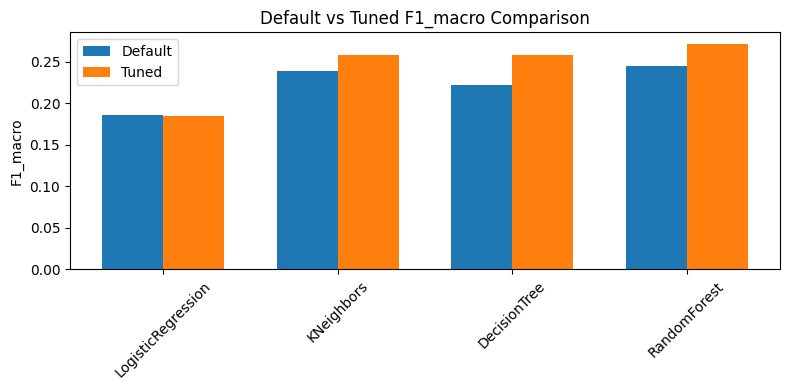

In [13]:
# 기본 모델의 F1 점수를 계산하여 DataFrame으로 저장
df_def = pd.DataFrame([
    {
        'Model': name,
        'F1_default': f1_score(
            y_test,
            model.predict(X_test),
            average='macro',
            zero_division=0
        )
    }
    for name, model in models.items()
]).set_index('Model')

# 튜닝된 모델 결과에서 F1_macro만 추출하여 DataFrame으로 설정
df_tuned = pd.DataFrame(results).set_index('Model')

# 기본 모델과 튜닝된 모델의 F1 값을 병합하여 비교용 프레임 생성
df_compare = df_def.join(
    df_tuned[['F1_macro']].rename(columns={'F1_macro': 'F1_tuned'})
)

# 시각화를 위해 모델 이름 리스트와 F1 점수 배열, x 좌표, 바 폭 설정
models_list = df_compare.index.tolist()
f1_def = df_compare['F1_default'].values
f1_tun = df_compare['F1_tuned'].values
x = np.arange(len(models_list))
width = 0.35

# 바 차트를 그려 기본 모델과 튜닝된 모델의 F1_macro 비교
fig, ax = plt.subplots(figsize=(8, 4))

# 기본 모델 바 차트
ax.bar(x - width/2, f1_def, width, label='Default')
# 튜닝된 모델 바 차트
ax.bar(x + width/2, f1_tun, width, label='Tuned')

# x축 눈금과 레이블 설정, 회전 적용
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45)

# y축 레이블과 제목 설정, 범례 표시
ax.set_ylabel('F1_macro')
ax.set_title('Default vs Tuned F1_macro Comparison')
ax.legend()

# 레이아웃 조정 및 차트 출력
plt.tight_layout()
plt.show()